In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import unicodedata
import re
import json

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from nltk import sent_tokenize
from prepare import prepare

import sklearn.preprocessing
import warnings
import re

from scipy import stats
from sklearn.feature_extraction.text import CountVectorizer
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
# imports for modeling
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
with open('data.json') as json_file:
    data = json.load(json_file)

In [3]:
df = pd.DataFrame(data)

# Check out prepare for prepare details

In [4]:
train,validate,test = prepare(df)

In [5]:
train.head()

,repo,language,readme_contents,clean,stemmed,lemmatized
63,Asabeneh/30-Days-Of-JavaScript,JavaScript,# 30 Days Of JavaScript\n\n| # Day | ...,30 days javascript day topics 01 introductionr...,30 day javascript day topic 01 introductionrea...,30 day javascript day topic 01 introductionrea...
18,MrS0m30n3/youtube-dl-gui,Python,[![Donations Badge](https://yourdonation.rocks...,donations badgehttpsyourdonationrocksimagesbad...,donat badgehttpsyourdonationrocksimagesbadgesv...,donation badgehttpsyourdonationrocksimagesbadg...
72,statianzo/Fleck,C#,Fleck\r\n===\r\n\r\n[![Build status](https://c...,fleck build statushttpsciappveyorcomapiproject...,fleck build statushttpsciappveyorcomapiproject...,fleck build statushttpsciappveyorcomapiproject...
12,ddbourgin/numpy-ml,Python,# numpy-ml\nEver wish you had an inefficient b...,numpyml ever wish inefficient somewhat legible...,numpyml ever wish ineffici somewhat legibl col...,numpyml ever wish inefficient somewhat legible...
88,mono/CppSharp,C#,CppSharp is a tool and set of libraries which ...,cppsharp tool set libraries facilitates usage ...,cppsharp tool set librari facilit usag nativ c...,cppsharp tool set library facilitates usage na...


In [6]:
train.shape, validate.shape, test.shape

((58, 6), (25, 6), (21, 6))

In [46]:
validate.language.value_counts()

HTML          10
JavaScript     5
C#             5
Python         5
Name: language, dtype: int64

# No duplicates

# Exploration

In [7]:
def clean(text):
    'A simple function to cleanup text data'
    
    ADDITIONAL_STOPWORDS = []
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [8]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(train, "language")

,n,percent
C#,18,0.310345
HTML,14,0.241379
JavaScript,13,0.224138
Python,13,0.224138


In [9]:
train.head()

,repo,language,readme_contents,clean,stemmed,lemmatized
63,Asabeneh/30-Days-Of-JavaScript,JavaScript,# 30 Days Of JavaScript\n\n| # Day | ...,30 days javascript day topics 01 introductionr...,30 day javascript day topic 01 introductionrea...,30 day javascript day topic 01 introductionrea...
18,MrS0m30n3/youtube-dl-gui,Python,[![Donations Badge](https://yourdonation.rocks...,donations badgehttpsyourdonationrocksimagesbad...,donat badgehttpsyourdonationrocksimagesbadgesv...,donation badgehttpsyourdonationrocksimagesbadg...
72,statianzo/Fleck,C#,Fleck\r\n===\r\n\r\n[![Build status](https://c...,fleck build statushttpsciappveyorcomapiproject...,fleck build statushttpsciappveyorcomapiproject...,fleck build statushttpsciappveyorcomapiproject...
12,ddbourgin/numpy-ml,Python,# numpy-ml\nEver wish you had an inefficient b...,numpyml ever wish inefficient somewhat legible...,numpyml ever wish ineffici somewhat legibl col...,numpyml ever wish inefficient somewhat legible...
88,mono/CppSharp,C#,CppSharp is a tool and set of libraries which ...,cppsharp tool set libraries facilitates usage ...,cppsharp tool set librari facilit usag nativ c...,cppsharp tool set library facilitates usage na...


# Modeling

In [10]:
#Create a baseline model

print(f'Baseline Accuracy:{train.language.value_counts().idxmax()} {round(max(train.language.value_counts()) / train.shape[0] *100)}%' )

Baseline Accuracy:C# 31%


In [11]:
def vectorizer_split(x):   
    vectorizer = CountVectorizer(binary = True, stop_words = 'english')
    vectorizer.fit(list(train[x]))
    X_train = vectorizer.transform(train[x])
    X_validate= vectorizer.transform(validate[x])
    X_test = vectorizer.transform(test[x])
    return X_train.todense(),X_validate.todense(),X_test.todense()

def tfidf_split(x):   
    tfidf = TfidfVectorizer()
    tfidf.fit(list(train[x]))
    X_train = tfidf.transform(train[x])
    X_validate= tfidf.transform(validate[x])
    X_test = tfidf.transform(test[x])
    return X_train.todense(),X_validate.todense(),X_test.todense()

def test_a_model(X_train, y_train, X_validate, y_validate, model, model_name, score_df):
    '''
    Function takes in X and y train
    X and y validate (or test) 
    A model with it's hyper parameters
    And a df to store the scores 
    - Set up an empty dataframe with score_df first
    - score_df = pd.DataFrame(columns = ['model_name', 'train_score', 'validate_score'])
    '''
    this_model = model

    this_model.fit(X_train, y_train)

    # Check with Validate

    train_score = this_model.score(X_train, y_train)
    
    validate_score = this_model.score(X_validate, y_validate)
    
    model_dict = {'model_name': model_name, 
                  'train_score': train_score, 
                  'validate_score':validate_score}
    score_df = score_df.append(model_dict, ignore_index = True)
    
    return score_df




In [12]:
y_train = train.language
y_validate = validate.language
y_test = test.language
X_train,X_validate,X_test = vectorizer_split('clean')

In [13]:
score_df = pd.DataFrame(columns = ['model_name', 'train_score', 'validate_score'])

In [14]:
def run_models():
    #Decision Tree
    ## Create a for loop that creates 20 decision tree models with increasingly larger depths.
    metrics = []
    tree_models = []
    for i in range(2, 22):
        # Make the model
        tree = DecisionTreeClassifier(max_depth=i, random_state=123)

        # Fit the model (on train and only train)
        tree = tree.fit(X_train, y_train)
        y_predictions = tree.predict(X_train)
        y_pred = tree.predict(X_validate)
        # Use the model
        in_sample_accuracy = round(tree.score(X_train, y_train),3)
    
        out_of_sample_accuracy = round(tree.score(X_validate, y_validate),3)
        
        in_sample_recall = round(sklearn.metrics.recall_score(y_train, y_predictions, pos_label=0, average='micro'),3)
        
        out_of_sample_recall = round(sklearn.metrics.recall_score(y_validate, y_pred, pos_label =0, average='micro'),3)
        output = {
            "max_depth": i,
            "train_accuracy": in_sample_accuracy,
            "validate_accuracy": out_of_sample_accuracy,
            "train_recall": in_sample_recall,
            "validate_recall": out_of_sample_recall
        }
        
        # This creates the df below
        metrics.append(output)
        # tree_models will store all of my tree models incase i want them later
        tree_models.append(tree)
        
    tree_df = pd.DataFrame(metrics)
    tree_df["accuracy_difference"] = tree_df.train_accuracy - tree_df.validate_accuracy    
    
    # Random Forest
    ## Create a for loop that creates 20 Random Forrest models with increasingly larger depths.
    metrics2 = []
    forest_models = []
    for i in range(2, 22):
        # Make the model
        forest = RandomForestClassifier(max_depth=i, random_state=123)
    
        # Fit the model (on train and only train)
        forest = forest.fit(X_train, y_train)
        
        y_predictions = forest.predict(X_train)
        y_pred = forest.predict(X_validate)
        
        # Use the model
        in_sample_accuracy = round(forest.score(X_train, y_train),3)
        
        out_of_sample_accuracy = round(forest.score(X_validate, y_validate),3)
        
        in_sample_recall = round(sklearn.metrics.recall_score(y_train, y_predictions, pos_label =0, average='micro'),3)
        
        out_of_sample_recall = round(sklearn.metrics.recall_score(y_validate, y_pred, pos_label =0, average='micro'),3)
        
        output = {
            "max_depth": i,
            "train_accuracy": in_sample_accuracy,
            "validate_accuracy": out_of_sample_accuracy,
            "train_recall": in_sample_recall,
            "validate_recall": out_of_sample_recall
        }
        
        # This creates the df below
        metrics2.append(output)
        # tree_models will store all of my tree models incase i want them later
        forest_models.append(forest)
        
        
        
    forest_df = pd.DataFrame(metrics2)
    forest_df["accuracy_difference"] = forest_df.train_accuracy - forest_df.validate_accuracy
    

    knn_metrics = []
    knn_models = []
    # loop through different values of k
    for k in range(1, 21):
            
        # define the thing
        knn = KNeighborsClassifier(n_neighbors=k)
        
        # fit the thing (remmeber only fit on training data)
        knn.fit(X_train, y_train)
        
        y_predictions = knn.predict(X_train)
        y_pred = knn.predict(X_validate)
        # use the thing (calculate accuracy)
        train_accuracy = round(knn.score(X_train, y_train),3)
        validate_accuracy = round(knn.score(X_validate, y_validate),3)
        train_recall = round(sklearn.metrics.recall_score(y_train, y_predictions, pos_label =0,average='micro'),3)
        validate_recall = round(sklearn.metrics.recall_score(y_validate, y_pred, pos_label =0,average='micro'),3)
        output = {
            "k": k,
            "train_accuracy": train_accuracy,
            "validate_accuracy": validate_accuracy,
            'train_recall':train_recall,
            "validate_recall":validate_recall
        }
        
        knn_metrics.append(output)
        knn_models.append(knn)
        # make a dataframe
    
    knn_df = pd.DataFrame(knn_metrics)
    knn_df["accuracy_difference"] = knn_df.train_accuracy - knn_df.validate_accuracy
        
    
    return tree_models, forest_models,knn_models, tree_df, forest_df, knn_df

In [15]:
X_train,X_validate,X_test = vectorizer_split('stemmed')

In [16]:
tree_models, forest_models,knn_models, tree_df, forest_df, knn_df = run_models()
from sklearn import svm
# make a list of algorithms we want to try for our models
model_list = [MultinomialNB(), LinearSVC(), tree_models[tree_df.validate_accuracy.idxmax()], forest_models[forest_df.accuracy_difference.idxmin()], knn_models[knn_df.validate_accuracy.idxmax()], LogisticRegression(), svm.SVC(C= 2, decision_function_shape='ovo')]

# name the models
model_names = ['Naive_Bayes_stemmed_CV', 'SVC_stemmed_CV', 'Decision_tree_stemmed_CV', 'Random_forest_stemmed_CV', 'KNN_stemmed_CV', 'Log_reg_stemmed_CV','SVC_OVO_stemmed_CV']
# Run the models
for model, name in zip(model_list, model_names):
    score_df = test_a_model(X_train, y_train, X_validate, y_validate, model, name, score_df)

In [17]:
score_df.style.highlight_max('validate_score')

,model_name,train_score,validate_score
0,Naive_Bayes_stemmed_CV,1.000000,0.520000
1,SVC_stemmed_CV,1.000000,0.480000
2,Decision_tree_stemmed_CV,0.913793,0.600000
3,Random_forest_stemmed_CV,0.862069,0.480000
4,KNN_stemmed_CV,0.465517,0.600000
5,Log_reg_stemmed_CV,1.000000,0.640000
6,SVC_OVO_stemmed_CV,0.913793,0.600000


In [18]:
X_train,X_validate,X_test = vectorizer_split('lemmatized')

In [19]:
tree_models, forest_models,knn_models, tree_df, forest_df, knn_df = run_models()
from sklearn import svm
# make a list of algorithms we want to try for our models
model_list = [MultinomialNB(), LinearSVC(), tree_models[tree_df.validate_accuracy.idxmax()], forest_models[forest_df.accuracy_difference.idxmin()], knn_models[knn_df.validate_accuracy.idxmax()], LogisticRegression(), svm.SVC(C= 2, decision_function_shape='ovo')]

# name the models
model_names = ['Naive_Bayes_lemmatized_CV', 'SVC_lemmatized_CV', 'Decision_tree_lemmatized_CV', 'Random_forest_lemmatized_CV', 'KNN_lemmatized_CV', 'Log_reg_lemmatized_CV','SVC_OVO_lemmatized_CV']
# Run the models
for model, name in zip(model_list, model_names):
    score_df = test_a_model(X_train, y_train, X_validate, y_validate, model, name, score_df)

In [20]:
score_df.style.highlight_max('validate_score')

,model_name,train_score,validate_score
0,Naive_Bayes_stemmed_CV,1.000000,0.520000
1,SVC_stemmed_CV,1.000000,0.480000
2,Decision_tree_stemmed_CV,0.913793,0.600000
3,Random_forest_stemmed_CV,0.862069,0.480000
4,KNN_stemmed_CV,0.465517,0.600000
5,Log_reg_stemmed_CV,1.000000,0.640000
6,SVC_OVO_stemmed_CV,0.913793,0.600000
7,Naive_Bayes_lemmatized_CV,1.000000,0.520000
8,SVC_lemmatized_CV,1.000000,0.480000
9,Decision_tree_lemmatized_CV,0.982759,0.600000


In [21]:
X_train,X_validate,X_test = tfidf_split('stemmed')

In [22]:
tree_models, forest_models,knn_models, tree_df, forest_df, knn_df = run_models()
from sklearn import svm
# make a list of algorithms we want to try for our models
model_list = [MultinomialNB(), LinearSVC(), DecisionTreeClassifier(), forest_models[forest_df.accuracy_difference.idxmin()], knn_models[knn_df.validate_accuracy.idxmax()], LogisticRegression(), svm.SVC(C= 2, decision_function_shape='ovo')]

# name the models
model_names = ['Naive_Bayes_stemmed_TFIDF', 'SVC_stemmed_TFIDF', 'Decision_tree_stemmed_TFIDF', 'Random_forest_stemmed_TFIDF', 'KNN_bigrams_stemmed_TFIDF', 'Log_reg_stemmed_TFIDF','SVC_OVO_stemmed_TFIDF']
# Run the models
for model, name in zip(model_list, model_names):
    score_df = test_a_model(X_train, y_train,X_validate, y_validate, model, name, score_df)

In [23]:
score_df.style.highlight_max('validate_score')

,model_name,train_score,validate_score
0,Naive_Bayes_stemmed_CV,1.000000,0.520000
1,SVC_stemmed_CV,1.000000,0.480000
2,Decision_tree_stemmed_CV,0.913793,0.600000
3,Random_forest_stemmed_CV,0.862069,0.480000
4,KNN_stemmed_CV,0.465517,0.600000
5,Log_reg_stemmed_CV,1.000000,0.640000
6,SVC_OVO_stemmed_CV,0.913793,0.600000
7,Naive_Bayes_lemmatized_CV,1.000000,0.520000
8,SVC_lemmatized_CV,1.000000,0.480000
9,Decision_tree_lemmatized_CV,0.982759,0.600000


In [24]:
X_train,X_validate,X_test = tfidf_split('lemmatized')

In [25]:
tree_models, forest_models,knn_models, tree_df, forest_df, knn_df = run_models()
from sklearn import svm
# make a list of algorithms we want to try for our models
model_list = [MultinomialNB(), LinearSVC(), tree_models[tree_df.validate_accuracy.idxmax()], forest_models[forest_df.validate_accuracy.idxmax()], knn_models[knn_df.validate_accuracy.idxmax()], LogisticRegression(), svm.SVC(C= 2, decision_function_shape='ovo')]

# name the models
model_names = ['Naive_Bayes_lemmatized_TFIDF', 'SVC_lemmatized_TFIDF', 'Decision_tree_lemmatized_TFIDF', 'Random_forest_lemmatized_TFIDF', 'KNN_lemmatized_TFIDF', 'Log_reg_lemmatized_TFIDF','SVC_OVO_lemmatized_TFIDF']
# Run the models
for model, name in zip(model_list, model_names):
    score_df = test_a_model(X_train, y_train, X_validate, y_validate, model, name, score_df)

In [26]:
score_df.style.highlight_max('validate_score')

,model_name,train_score,validate_score
0,Naive_Bayes_stemmed_CV,1.000000,0.520000
1,SVC_stemmed_CV,1.000000,0.480000
2,Decision_tree_stemmed_CV,0.913793,0.600000
3,Random_forest_stemmed_CV,0.862069,0.480000
4,KNN_stemmed_CV,0.465517,0.600000
5,Log_reg_stemmed_CV,1.000000,0.640000
6,SVC_OVO_stemmed_CV,0.913793,0.600000
7,Naive_Bayes_lemmatized_CV,1.000000,0.520000
8,SVC_lemmatized_CV,1.000000,0.480000
9,Decision_tree_lemmatized_CV,0.982759,0.600000


In [27]:
score_df["accuracy_difference"] = score_df.train_score - score_df.validate_score

In [28]:
score_df.style.highlight_max('validate_score').highlight_min('accuracy_difference')

,model_name,train_score,validate_score,accuracy_difference
0,Naive_Bayes_stemmed_CV,1.000000,0.520000,0.480000
1,SVC_stemmed_CV,1.000000,0.480000,0.520000
2,Decision_tree_stemmed_CV,0.913793,0.600000,0.313793
3,Random_forest_stemmed_CV,0.862069,0.480000,0.382069
4,KNN_stemmed_CV,0.465517,0.600000,-0.134483
5,Log_reg_stemmed_CV,1.000000,0.640000,0.360000
6,SVC_OVO_stemmed_CV,0.913793,0.600000,0.313793
7,Naive_Bayes_lemmatized_CV,1.000000,0.520000,0.480000
8,SVC_lemmatized_CV,1.000000,0.480000,0.520000
9,Decision_tree_lemmatized_CV,0.982759,0.600000,0.382759


In [29]:
tree_models[tree_df.validate_accuracy.idxmax()]

DecisionTreeClassifier(max_depth=3, random_state=123)

In [37]:
def make_models_and_print_metrics_test_data(model, model_name, X_train, y_train, X_test, y_test, class_names):
    '''
    This function takes in a model object,
    Name for the model (for vis purposes)
    X_train, y_train
    X_test and y_test
    and the names of your classes (aka category names)
    Uses print metrics function 
    Use this function on the final test data set. 
    '''
    model.fit(X_train, y_train)

    test_pred = model.predict(X_test)
    
    print(f'                   ============== {model_name} ================           ')
    #print metrics for Test
    print_metrics(model, X_test, y_test, test_pred, class_names, set_name='Test')
    print('-------------------------------------------------------------------\n')
    
    
    
def print_metrics(model, X, y, pred, class_names, set_name = 'This Set'):
    '''
    This function takes in a model, 
    X dataframe
    y dataframe 
    predictions 
    Class_names (aka ['Java', 'Javascript', 'Jupyter Notebook', 'PHP'])
    and a set name (aka train, validate or test)
    Prints out a classification report 
    and confusion matrix as a heatmap
    To customize colors change insdie the function
    - IMPORTANT change lables inside this function
    '''
    
    
    print(model)
    print(f"~~~~~~~~{set_name} Scores~~~~~~~~~")
    print(classification_report(y, pred))
    
    #purple_cmap = sns.cubehelix_palette(as_cmap=True)
    purple_cmap = sns.color_palette("light:indigo", as_cmap=True)
    
    with sns.axes_style("white"):
        matrix = plot_confusion_matrix(model,X, y, display_labels=class_names, 
                                       cmap = purple_cmap)
        plt.grid(False)
        plt.show()
        print()


                   ============== Decisiocion Tree ================           
DecisionTreeClassifier(max_depth=3, random_state=123)
~~~~~~~~Test Scores~~~~~~~~~
              precision    recall  f1-score   support

          C#       0.36      1.00      0.53         4
        HTML       0.75      0.60      0.67         5
  JavaScript       1.00      0.40      0.57         5
      Python       1.00      0.57      0.73         7

    accuracy                           0.62        21
   macro avg       0.78      0.64      0.62        21
weighted avg       0.82      0.62      0.64        21



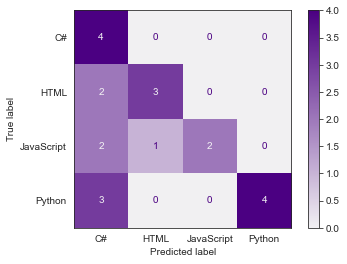


-------------------------------------------------------------------



In [45]:
class_names = ['C#', 'HTML', 'JavaScript','Python' ]
make_models_and_print_metrics_test_data(tree_models[tree_df.validate_accuracy.idxmax()], 'Decisiocion Tree', X_train, y_train, X_test, y_test, class_names)